* Bayesian Dropout & GradCAM on MNIST
* See,
    * https://arxiv.org/abs/1506.02142
    * https://arxiv.org/abs/1610.02391

In [2]:
import gzip
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

* Using data is MNIST, downloading without chainer etc.
* See http://yann.lecun.com/exdb/mnist/

In [4]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P ./data
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P ./data
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P ./data
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P ./data

--2018-08-11 11:47:40--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: './data/train-images-idx3-ubyte.gz'

train-images-idx3-u 100%[===================>]   9.45M  10.3MB/s    in 0.9s    

2018-08-11 11:47:41 (10.3 MB/s) - './data/train-images-idx3-ubyte.gz' saved [9912422/9912422]

--2018-08-11 11:47:41--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: './data/train-labels-idx1-ubyte.gz'

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.08s   

2018-08-11 11:47:42 (364 KB/

In [5]:
ls ./data

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [6]:
with gzip.open('./data/train-images-idx3-ubyte.gz', 'rb') as f:
    train_x = np.frombuffer(f.read(), np.uint8, offset=16)
    train_x = train_x.reshape(60000, 28, 28)
    
with gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    valid_x = np.frombuffer(f.read(), np.uint8, offset=16)
    valid_x = valid_x.reshape(10000, 28, 28)

with gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_y = np.frombuffer(f.read(), np.uint8, offset=8)
    
with gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    valid_y = np.frombuffer(f.read(), np.uint8, offset=8)
    
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
train_sample_index = np.random.choice(60000, size=30000)
train_x_sample = train_x[train_sample_index, :, :]
train_y_sample = train_y[train_sample_index]
valid_sample_index = np.random.choice(10000, size=1000)
valid_x_sample = valid_x[valid_sample_index, :, :]
valid_y_sample = valid_y[valid_sample_index]
train_x_sample.shape, train_y_sample.shape, valid_x_sample.shape, valid_y_sample.shape

((30000, 28, 28), (30000,), (1000, 28, 28), (1000,))

* Set Model

In [8]:
class Model(chainer.Chain):
    
    def __init__(self):
        
        super(Model, self).__init__(
            conv1 = L.Convolution2D(3, 16, 3),
            conv2 = L.Convolution2D(16, 32, 3),
            fc3 = L.Linear(None, 100),
            fc4 = L.Linear(100, 10)
        )
    
    def __call__(self, x, gradcam=False):
        
        h1 = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h2 = F.max_pooling_2d(F.relu(self.conv2(h1)), 2)
        h3 = F.dropout(F.relu(self.fc3(h2)))
        y = self.fc4(h3)
        
        if gradcam:
            return {'y': y, 'conv2': h2}
        
        return y

* Set train, valid dataset

In [10]:
class TransformDataset(chainer.dataset.DatasetMixin):
    
    def __init__(self, data):
        
        self.data = data
        
    def __len__(self):
        
        return len(self.data)
    
    def get_example(self, i):
        
        x, y = self.data[i][0], self.data[i][1]
        return x, y

In [11]:
def to_rgb(x):
    
    w, h = x.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = x
    ret[:, :, 1] = x
    ret[:, :, 2] = x
    return ret

In [12]:
train_dataset = TransformDataset([(to_rgb(x).transpose(2, 0, 1).astype(np.float32), np.int32(y)) for x, y in zip(train_x_sample, train_y_sample)])
valid_dataset = TransformDataset([(to_rgb(x).transpose(2, 0, 1).astype(np.float32), np.int32(y)) for x, y in zip(valid_x_sample, valid_y_sample)])
len(train_dataset), len(valid_dataset)

(30000, 1000)

* Train

In [13]:
gpu = 0

model = L.Classifier(Model())
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu()

In [14]:
epoch_num = 20
batch_size = 100

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, 1, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))
trainer.extend(extensions.LogReport(trigger=(5, 'epoch')))
trainer.extend(extensions.snapshot_object(model, filename='model_epoch_{.updater.epoch}.npz'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
5           0.992161    0.268985              0.742581       0.9308                    30.0008       
10          0.218395    0.0849231             0.925444       0.9768                    56.4903       
15          0.13643     0.0737377             0.953366       0.9804                    82.935        
20          0.105172    0.0695207             0.963737       0.9802                    109.426       


* Test GradCAM

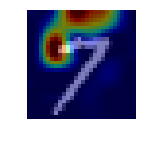

In [17]:
img, y = valid_dataset.get_example(0)
x = img[np.newaxis]
x = chainer.cuda.to_gpu(x)

with chainer.using_config('train', False):
    
    acts = model.predictor(x, gradcam=True)
    one_hot = model.xp.zeros((1, 10), dtype=np.float32)
    one_hot[:, y] = 1
    model.cleargrads()
    loss = F.sum(chainer.Variable(one_hot)*F.log_softmax(acts['y']))
    loss.backward(retain_grad=True)
    
cam = acts['conv2']
w = model.xp.mean(cam.grad, axis=(2, 3))
gcam = model.xp.tensordot(w[0], cam.data[0], axes=(0, 0))
gcam = chainer.cuda.to_cpu(gcam)
gcam = (gcam > 0) * gcam / gcam.max() * 255
gcam = Image.fromarray(gcam)
gcam = gcam.resize(x.shape[2:4], 1)
gcam = np.array(gcam)

m = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 1), cmap=matplotlib.cm.jet)
overlay = Image.fromarray((m.to_rgba(gcam/255) * 255).astype(np.uint8))
img = Image.fromarray(img.transpose(1, 2, 0).astype(np.uint8)).convert('RGBA')
blended = Image.blend(img, overlay, 0.5)

plt.figure(figsize=(2,2))
plt.imshow(blended)
plt.axis('off')
plt.show()

* show high and low entropy x image and GradCAM.

In [24]:
def gradcam(x, y, img, ax):
    
    x = chainer.cuda.to_gpu(x)
    
    with chainer.using_config('train', False):

        acts = model.predictor(x, gradcam=True)
        one_hot = model.xp.zeros((1, 10), dtype=np.float32)
        one_hot[:, y] = 1
        model.cleargrads()
        loss = F.sum(chainer.Variable(one_hot)*F.log_softmax(acts['y']))
        loss.backward(retain_grad=True)

    cam = acts['conv2']
    w = model.xp.mean(cam.grad, axis=(2, 3))
    gcam = model.xp.tensordot(w[0], cam.data[0], axes=(0, 0))
    gcam = chainer.cuda.to_cpu(gcam)
    gcam = (gcam > 0) * gcam / gcam.max() * 255 if gcam.max() > 0 else (gcam > 0) * gcam * 255
    gcam = Image.fromarray(gcam)
    gcam = gcam.resize(x.shape[2:4], 1)
    gcam = np.array(gcam)

    m = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 1), cmap=matplotlib.cm.jet)
    overlay = Image.fromarray((m.to_rgba(gcam/255) * 255).astype(np.uint8))
    img = Image.fromarray(img).convert('RGBA')
    blended = Image.blend(img, overlay, 0.5)

    ax.imshow(blended)
    ax.axis('off')

def plots(target_num):

    imgs = valid_x[np.where(valid_y == target_num)[0]]

    sampling_num = 50
    arr_entropy = np.zeros((len(imgs)), dtype=np.float32)

    for i in tqdm(range(len(imgs))):

        x = to_rgb(imgs[i]).transpose(2, 0, 1).astype(np.float32)
        x = x[np.newaxis]
        x = chainer.cuda.to_gpu(x)

        preds = np.zeros((sampling_num, 10), dtype=np.float32)

        for j in range(sampling_num):

            with chainer.using_config('train', True):
                
                preds[j, :] = chainer.cuda.to_cpu(F.softmax(model.predictor(x), axis=1).data.squeeze())

        preds = preds.mean(axis=0)
        arr_entropy[i] = np.sum(-preds*np.log(preds))

    high_entropy_idxs = np.argsort(arr_entropy)[::-1][:30]
    low_entropy_idxs = np.argsort(arr_entropy)[:30]

    fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 5))

    for i in range(0, 30, 10):
        for j in range(10):

            y = np.int32(target_num)
            img = imgs[low_entropy_idxs[i+j]]
            img = to_rgb(img)
            x = img.transpose(2, 0, 1).astype(np.float32)[np.newaxis]
            
            gradcam(x=x, y=y, img=img, ax=axs[i//10, j])

    plt.suptitle('low entropy TOP 30 (GradCAM)')
    plt.show()

    fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 5))

    for i in range(0, 30, 10):
        for j in range(10):

            y = np.int32(target_num)
            img = imgs[high_entropy_idxs[i+j]]
            img = to_rgb(img)
            x = img.transpose(2, 0, 1).astype(np.float32)[np.newaxis]
            
            gradcam(x=x, y=y, img=img, ax=axs[i//10, j])

    plt.suptitle('high entropy TOP 30 (GradCAM)')
    plt.show()

100%|██████████| 980/980 [01:35<00:00, 10.21it/s]


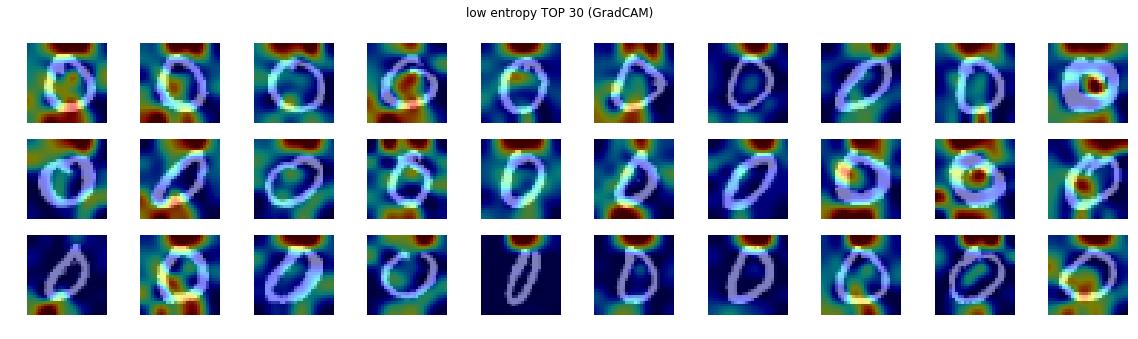

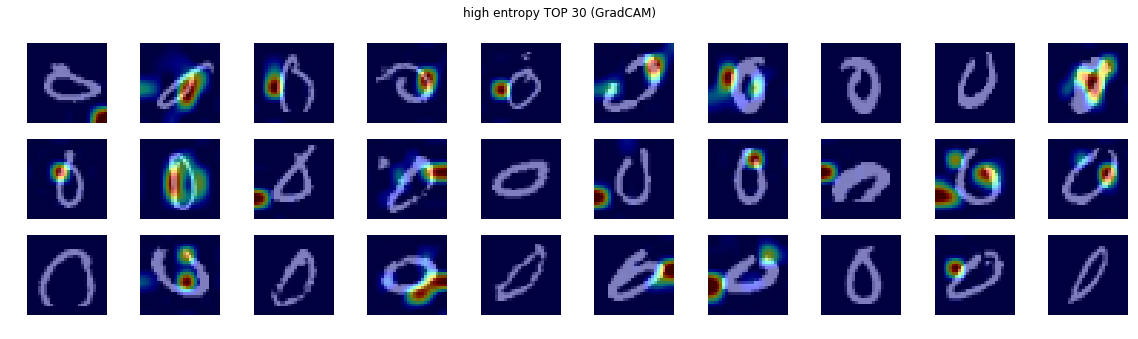

In [25]:
plots(0)

100%|██████████| 1135/1135 [01:51<00:00, 10.14it/s]


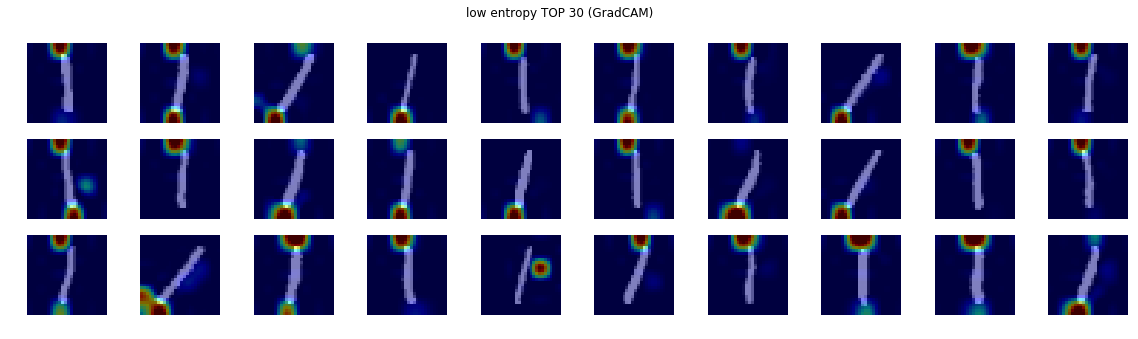

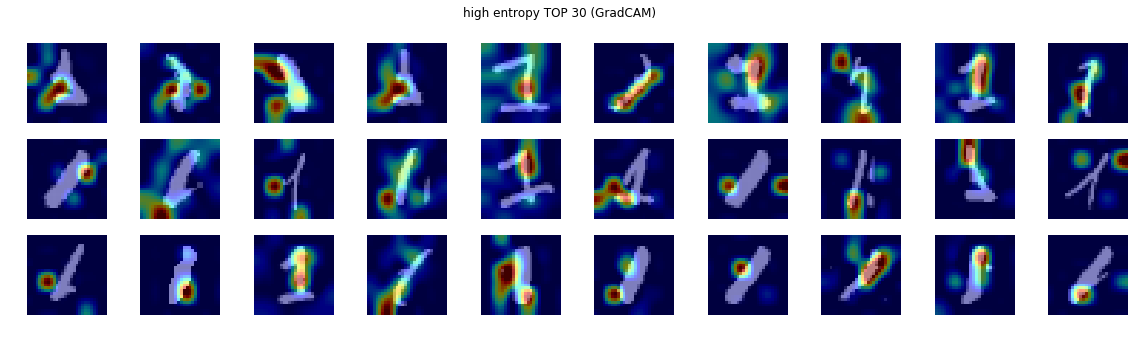

In [26]:
plots(1)

100%|██████████| 1032/1032 [01:41<00:00, 10.14it/s]


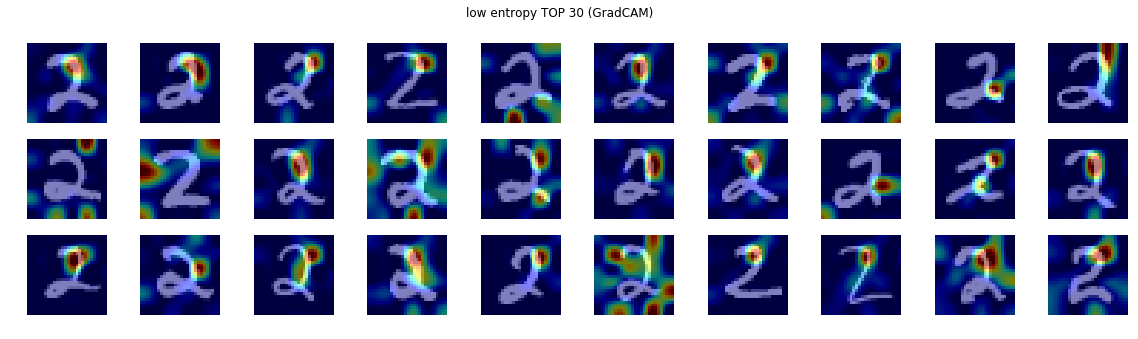

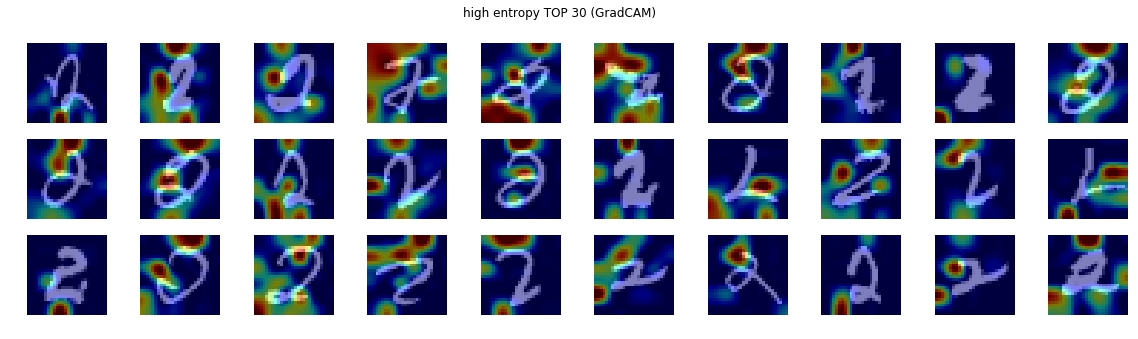

In [27]:
plots(2)

100%|██████████| 1010/1010 [01:40<00:00, 10.09it/s]


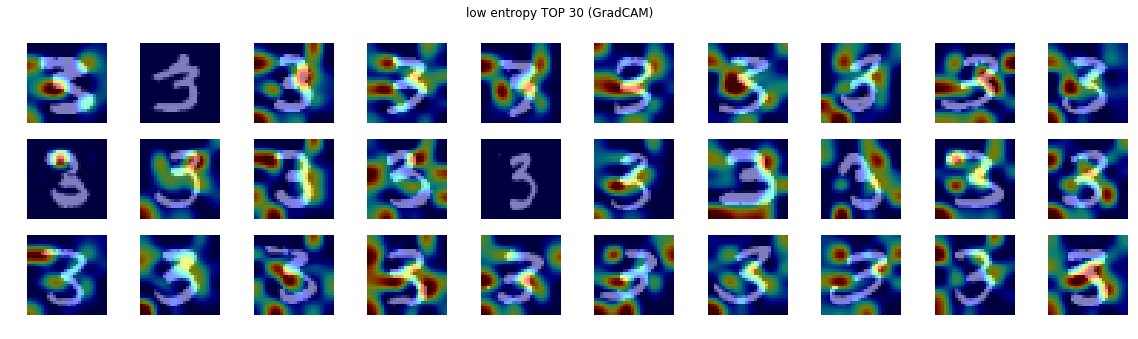

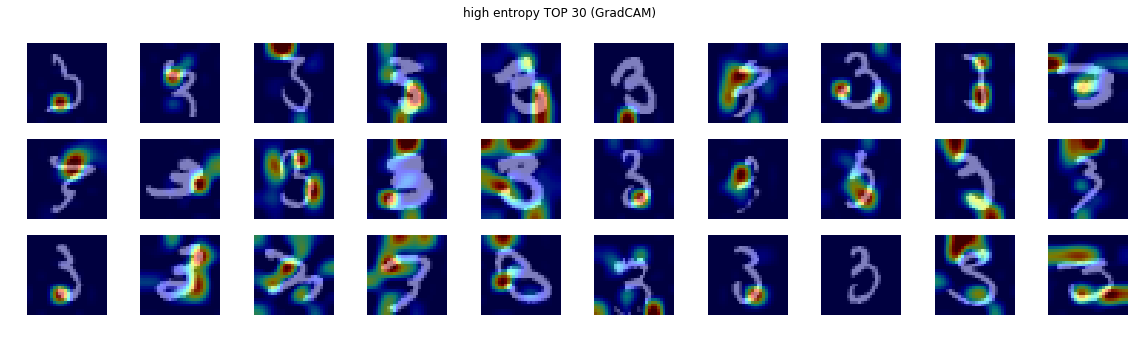

In [28]:
plots(3)

100%|██████████| 982/982 [01:37<00:00, 10.11it/s]


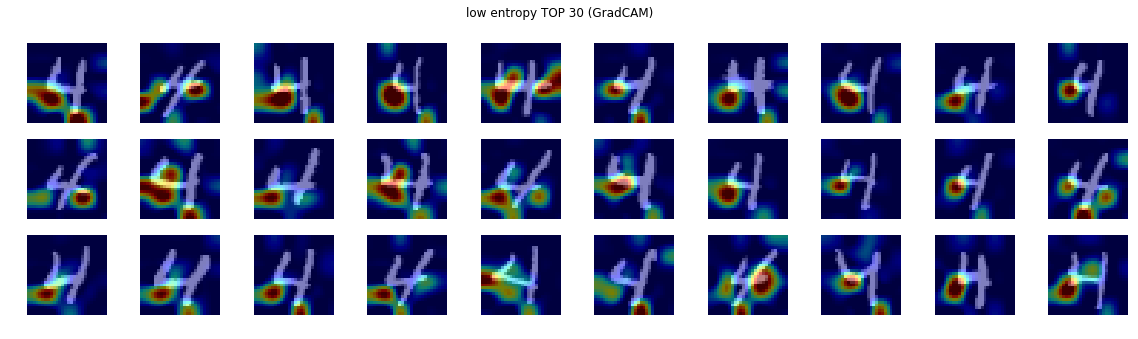

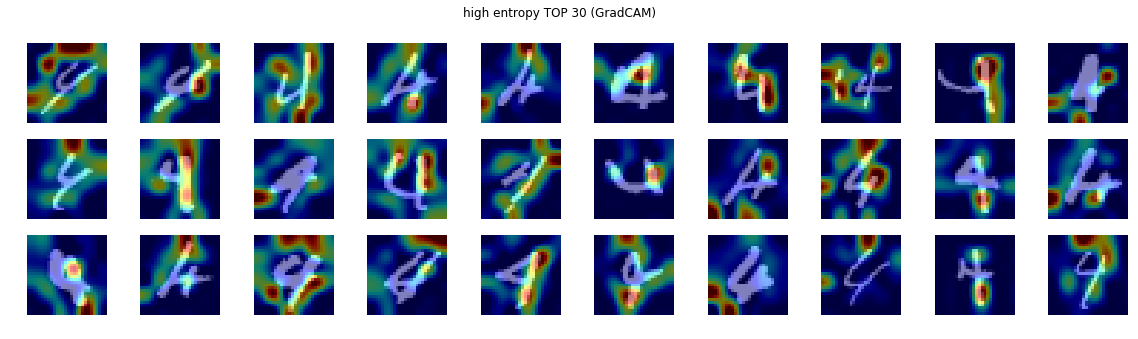

In [29]:
plots(4)

100%|██████████| 892/892 [01:27<00:00, 10.16it/s]


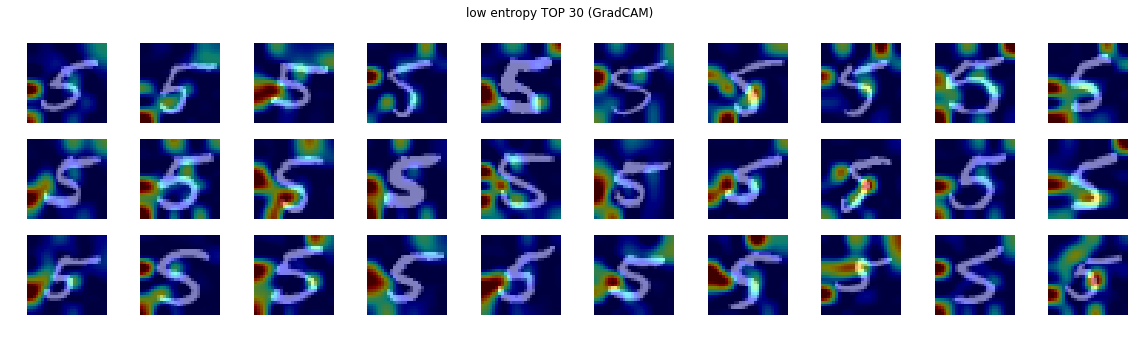

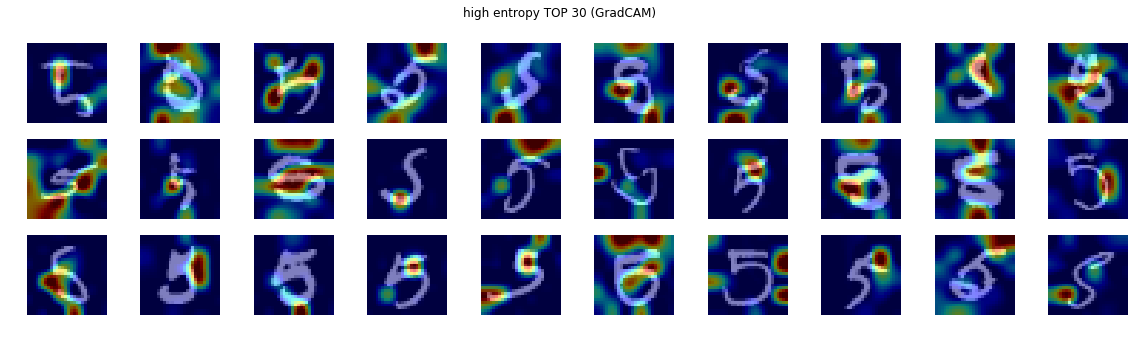

In [30]:
plots(5)

100%|██████████| 958/958 [01:34<00:00, 10.15it/s]


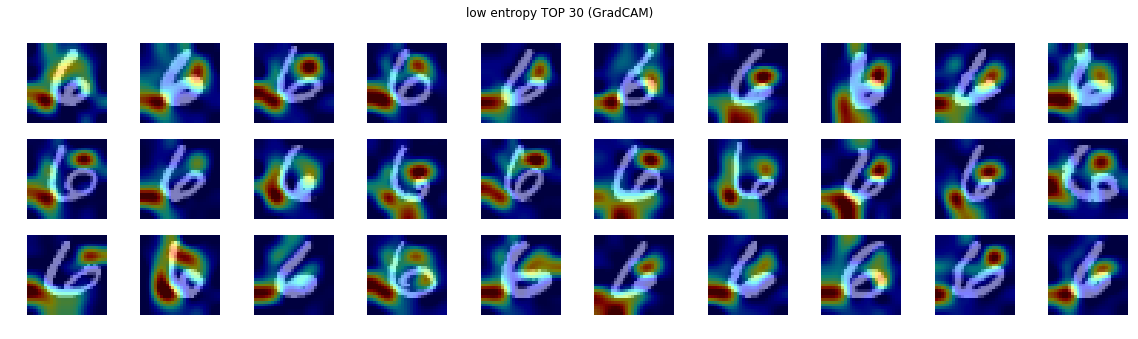

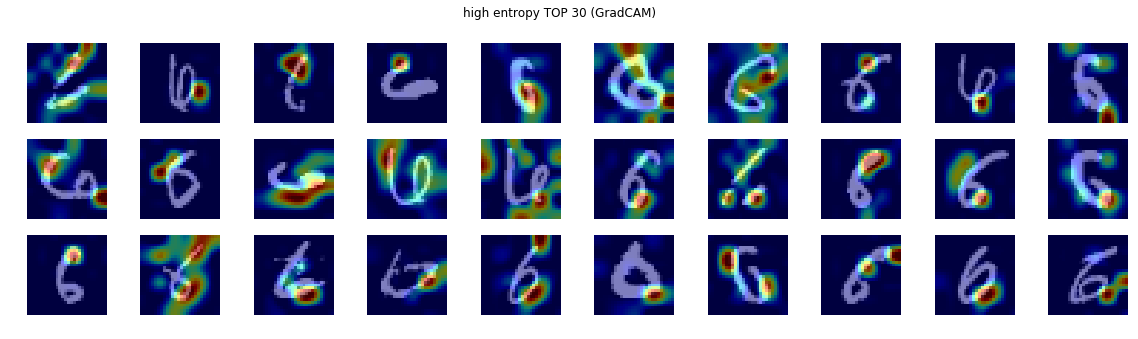

In [31]:
plots(6)

100%|██████████| 1028/1028 [01:42<00:00, 10.07it/s]


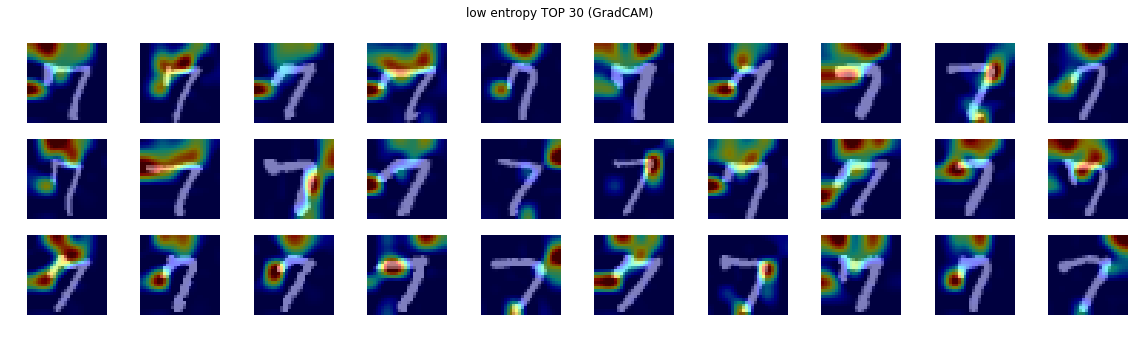

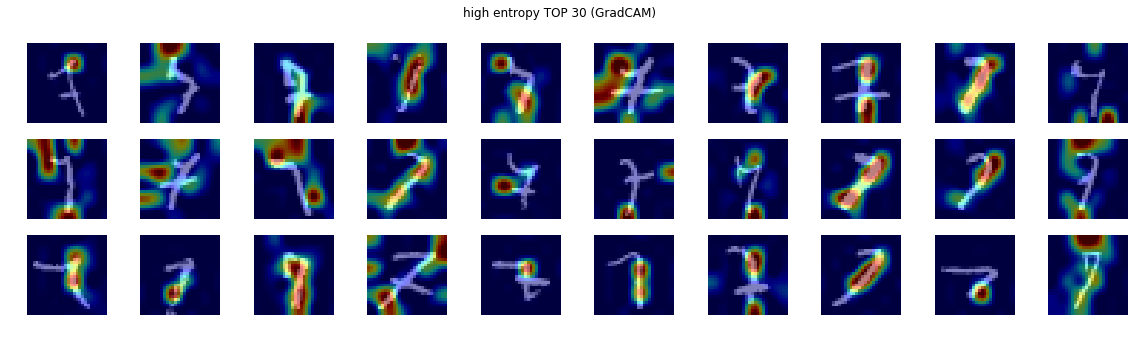

In [32]:
plots(7)

100%|██████████| 974/974 [01:35<00:00, 10.17it/s]


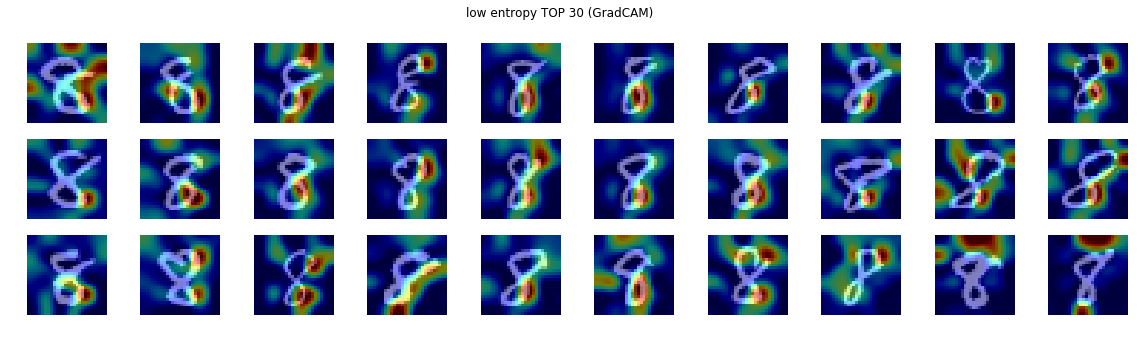

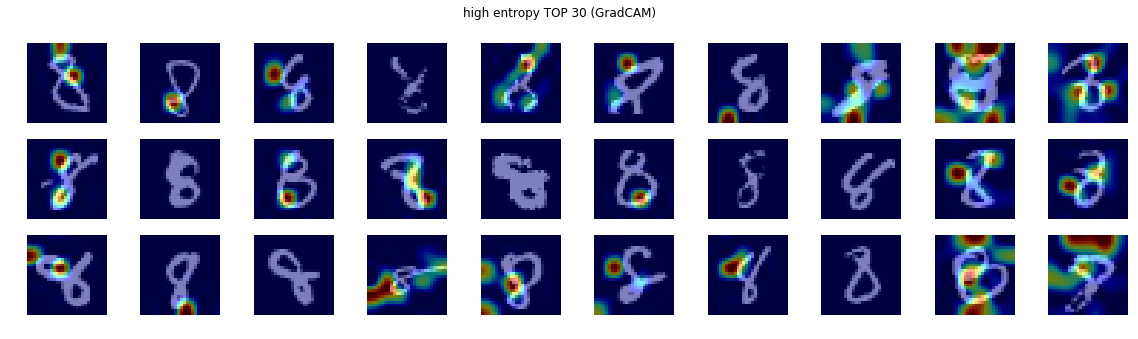

In [33]:
plots(8)

100%|██████████| 1009/1009 [01:39<00:00, 10.16it/s]


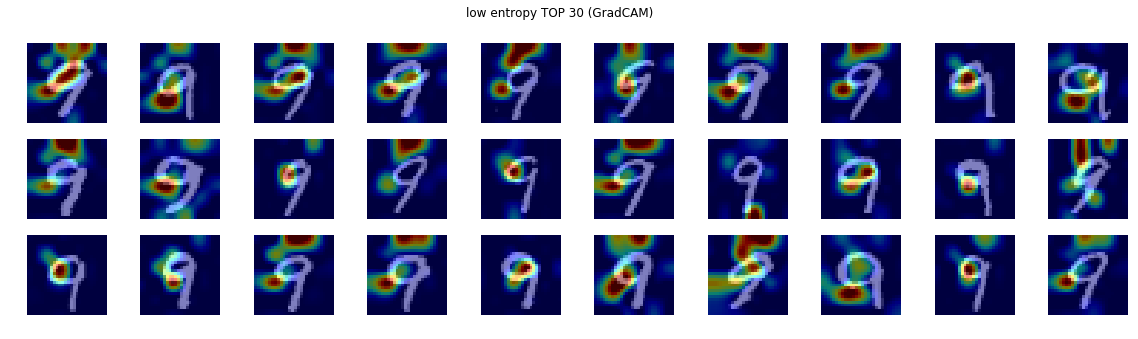

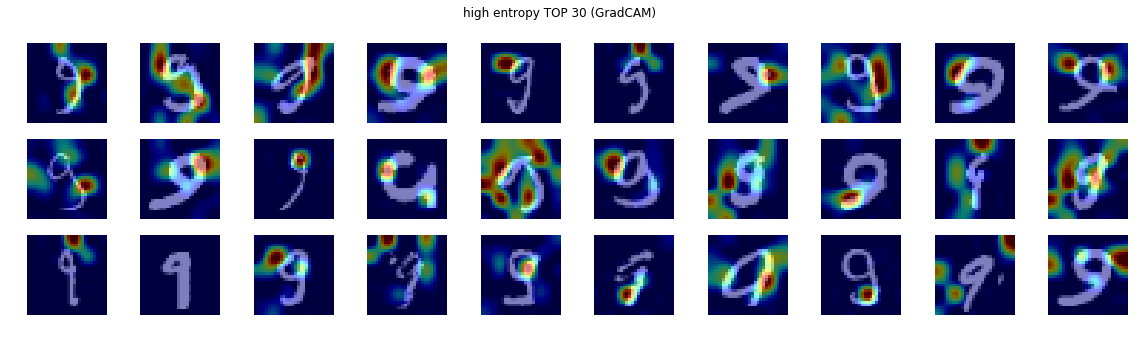

In [34]:
plots(9)

In [35]:
!python --version

Python 3.6.3


In [36]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [37]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [38]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
